In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split

/home/joseph/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# creating sql connection string
con = sqlite3.connect('database.sqlite')

In [3]:
filtered_data = pd.read_sql_query('SELECT * from Reviews WHERE Score != 3',con)

In [4]:
actual_scores = filtered_data['Score']
positiveNegative = actual_scores.map(lambda x: 'Positive' if x>3 else 'Negative')
filtered_data['Score'] = positiveNegative

In [5]:
final = filtered_data.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})

In [6]:
print('Rows dropped : ',filtered_data.size - final.size)
print('Percentage Data remaining after dropping duplicates :',(((final.size * 1.0)/(filtered_data.size * 1.0) * 100.0)))

Rows dropped :  1616410
Percentage Data remaining after dropping duplicates : 69.25890143662969


In [7]:
# Dropping rows where HelpfulnessNumerator < HelpfulnessDenominator
final = final[final.HelpfulnessDenominator >= final.HelpfulnessNumerator]

In [8]:
print('Number of Rows remaining in the Dataset: ',final.size)

Number of Rows remaining in the Dataset:  3641710


In [9]:
# Data Sampling
final = final.iloc[:50000,:]


# Checking the number of positive and negative reviews

Class_Count  = final['Score'].value_counts()
print(final['Score'].value_counts())

Positive    41815
Negative     8185
Name: Score, dtype: int64


In [10]:
# Sorting values according to Time for Time Based Slicing
final = final.sort_values('Time',kind = 'quicksort')

In [11]:
# Function to Remove HTML Tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner,"",sentence)
    return cleantext

In [12]:
# Function to clean punctuations and special characters

def cleanpunct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
# Initialize Stop words and PorterStemmer and Lemmetizer
stop = set(stopwords.words('english'))
sno = SnowballStemmer('english')

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [15]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review
final.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,Positive,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,Positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'receiv shipment could hard wait tri product ...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,Positive,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,b'love stuff doesnt rot gum tast good go buy g...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,Positive,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",b'noth product bother link top page buy use ch...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,Positive,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",b'fresh lime underappreci joy kitchen squirt l...


# BOW

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000, 25048)
Test Data Size:  (15000, 25048)


In [17]:

%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty':['l1','l2'] }

sol = GridSearchCV(clf,param_grid,verbose=1)

sol.fit(X_train,y_train)

print('Best C:', sol.best_estimator_.get_params()['C'])
print("Best Accuracy: %.2f%%"%(sol.best_score_*100))


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs
Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   31.0s finished


Best C: 10
Best Accuracy: 91.21%


In [19]:

def plot_error_vs_c(type):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    
    for a in sol.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1 - a[1])
            x1.append(a[0]['C'])
            
        else:
            y2.append(1 - a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
#plot_error_vs_c(sol)

/home/joseph/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


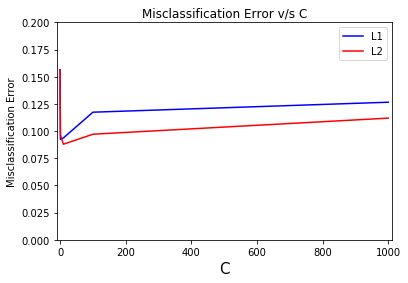

In [20]:

plot_error_vs_c(sol)

Accuracy on test set: 90.87
Precision on test set: 86.8
Recall on test set: 80.58
F1-Score on test set:  83.19
Non Zero weights: 25048


Text(0.5,15,'Predicted label')

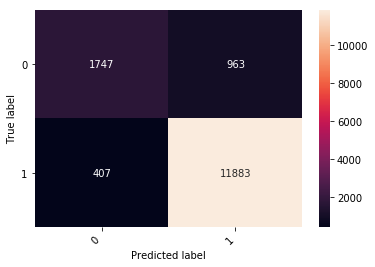

In [21]:
#Testing Accuracy on Test data
import numpy as np
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Precision on test set:",np.round((precision_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Recall on test set:",np.round((recall_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,y_pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')


# sparsity increases as we increase lambda or decrease C

In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.59
F1-Score on test set:  76.35
Non Zero weights: 6878


In [23]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.49
F1-Score on test set:  78.65
Non Zero weights: 6350


In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.41
F1-Score on test set:  82.89
Non Zero weights: 3543


# Randomized search

In [25]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}

sol1 = RandomizedSearchCV(clf,param_grid,verbose=1)
sol1.fit(X_train,y_train)

print("Best HyperParameter: ",sol1.best_params_)
print("Best Accuracy: %.2f%%"%(sol1.best_score_*100))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.9s finished


Best HyperParameter:  {'penalty': 'l1', 'C': 5}
Best Accuracy: 91.05%


Accuracy on test set: 90.94
Precision on test set: 87.46
Recall on test set: 80.09
F1-Score on test set:  83.09
Non Zero weights: 25048


Text(0.5,15,'Predicted label')

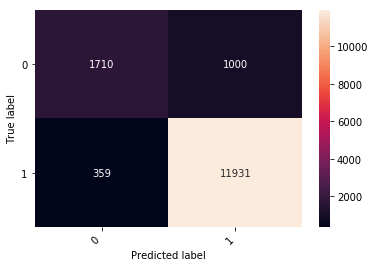

In [26]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Precision on test set:",np.round((precision_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Recall on test set:",np.round((recall_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,y_pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')




In [27]:
def plot_error_vs_c(sol1):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    
    for a in sol1.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1 - a[1])
            x1.append(a[0]['C'])
            
        else:
            y2.append(1 - a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()

/home/joseph/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


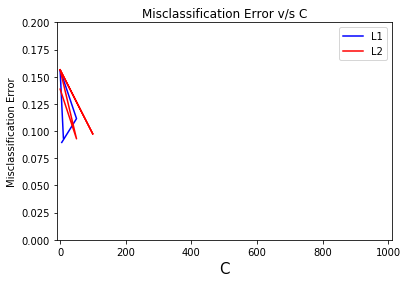

In [28]:

plot_error_vs_c(sol1)

# Perturbation test

In [29]:


clf = LogisticRegression(C = 10, penalty = 'l2')

clf.fit(X_train, y_train)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Non zero weights:" , np.count_nonzero(clf.coef_))



Accuracy on test set: 90.94
Non zero weights: 25048


In [30]:
from scipy.sparse import find

#weights before adding random noise

weights1 = find(clf.coef_)[2]

print(weights1)

[0.00082506 0.01594252 0.01594252 ... 0.02158355 0.14265074 0.0321364 ]


In [31]:

X_train_1 = X_train

epsilon = np.random.uniform(low = -0.0001, high = 0.0001, size = (find(X_train_1)[0].size,))

print(type(X_train_1))

# positions(row,cloumn) and value of non-zero datapoints
a,b,c = find(X_train_1)


X_train_1[a,b] = epsilon + X_train_1[a,b] 




<class 'scipy.sparse.csr.csr_matrix'>


In [32]:
# Traininig with random noise

clf = LogisticRegression(C = 10, penalty = 'l2')

clf.fit(X_train, y_train)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Non zero weights:" , np.count_nonzero(clf.coef_))

Accuracy on test set: 90.94
Non zero weights: 25048


In [33]:
from scipy.sparse import find

#weights before adding random noise

weights2 = find(clf.coef_)[2]

print(weights2)

[0.00081522 0.01587308 0.01587505 ... 0.02141253 0.14299171 0.03219629]


In [34]:
weights_diff = (abs(weights1 - weights2)/weights1)*100

In [35]:
print(weights_diff[np.where(weights_diff > 30)].size)

9


2 features are multicolinear

In [36]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(uni_gram,clf)

			Positive						Negative
________________________________________________________________________________________________
	-13.8827	worst          				9.8597	perfect        
	-10.0878	terribl        				9.6304	delici         
	-9.4728	bland          				9.2832	amaz           
	-9.4019	aw             				8.7039	excel          
	-9.2288	disappoint     				8.3004	worri          
	-8.7619	return         				7.8243	yummi          
	-8.5215	threw          				7.5773	glad           
	-8.2068	cancel         				7.3243	fantast        
	-8.0147	trash          				7.2958	best           
	-7.7787	shame          				7.2493	awesom         
	-7.7036	horribl        				7.1710	satisfi        
	-7.6648	disgust        				7.0349	smooth         
	-7.2374	unfortun       				6.8765	great          
	-7.0978	weak           				6.7810	addict         
	-7.0055	yuck           				6.6629	nice           
	-6.8512	flat           				6.6524	skeptic        
	-6.7647	die            				6.5886	thank          
	-6.6031

# tf-idf

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
tfidf = TfidfVectorizer(ngram_range=(1,2)) 
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000, 589268)
Test Data Size:  (15000, 589268)


In [38]:

%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty':['l1','l2'] }

sol_tfidf = GridSearchCV(clf,param_grid,verbose=1)

sol_tfidf.fit(X_train,y_train)

print('Best C:', sol_tfidf.best_estimator_.get_params()['C'])
print("Best Accuracy: %.2f%%"%(sol_tfidf.best_score_*100))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  1.0min finished


Best C: 1000
Best Accuracy: 91.47%


In [40]:
def plot_error_vs_c(type):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    
    for a in sol_tfidf.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1 - a[1])
            x1.append(a[0]['C'])
            
        else:
            y2.append(1 - a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()

/home/joseph/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


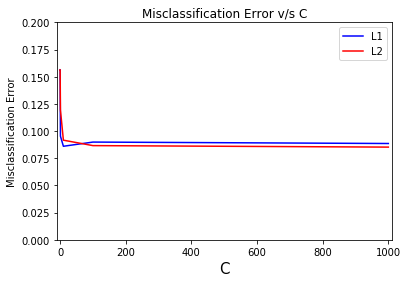

In [41]:
plot_error_vs_c(sol_tfidf)

Accuracy on test set: 91.48
Precision on test set: 89.68
Recall on test set: 79.94
F1-Score on test set:  83.69
Non Zero weights: 589268


Text(0.5,15,'Predicted label')

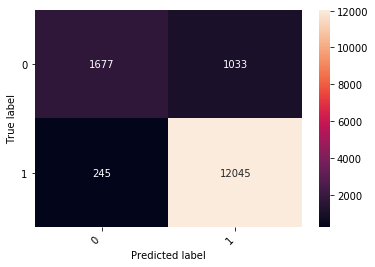

In [42]:
#Testing Accuracy on Test data
import numpy as np
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Precision on test set:",np.round((precision_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Recall on test set:",np.round((recall_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,y_pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Sparsity v/s C

In [43]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.25
F1-Score on test set:  84.47
Non Zero weights: 11131


In [44]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.13
F1-Score on test set:  84.4
Non Zero weights: 8272


In [45]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.56
F1-Score on test set:  84.98
Non Zero weights: 5679


# Randomized search

In [46]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}

sol_tfidf_random = RandomizedSearchCV(clf,param_grid,verbose=1)
sol_tfidf_random.fit(X_train,y_train)

print("Best HyperParameter: ",sol_tfidf_random.best_params_)
print("Best Accuracy: %.2f%%"%(sol_tfidf_random.best_score_*100))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   36.2s finished


Best HyperParameter:  {'penalty': 'l1', 'C': 5}
Best Accuracy: 91.51%


Accuracy on test set: 91.31
Precision on test set: 89.93
Recall on test set: 79.12
F1-Score on test set:  83.14
Non Zero weights: 589268


Text(0.5,15,'Predicted label')

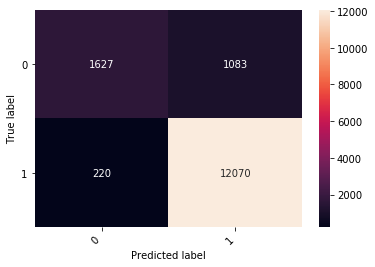

In [47]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Precision on test set:",np.round((precision_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Recall on test set:",np.round((recall_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,y_pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [48]:
def plot_error_vs_c(sol_tfidf_random):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    
    for a in sol_tfidf_random.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1 - a[1])
            x1.append(a[0]['C'])
            
        else:
            y2.append(1 - a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()

/home/joseph/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


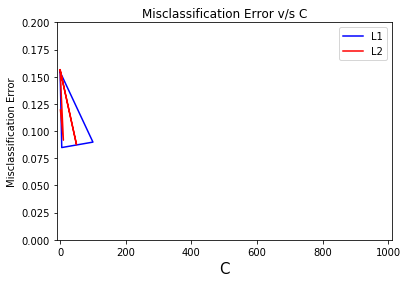

In [49]:
plot_error_vs_c(sol_tfidf_random)

# Perturbation test

In [39]:
clf = LogisticRegression(C = 10, penalty = 'l2')

clf.fit(X_train, y_train)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Non zero weights:" , np.count_nonzero(clf.coef_))

Accuracy on test set: 90.94
Non zero weights: 589268


In [40]:
from scipy.sparse import find

#weights before adding random noise

weights1 = find(clf.coef_)[2]

print(weights1)

[0.00364381 0.0288931  0.0288931  ... 0.07256389 0.04988143 0.04988143]


In [41]:
X_train_1 = X_train

epsilon = np.random.uniform(low = -0.0001, high = 0.0001, size = (find(X_train_1)[0].size,))

print(type(X_train_1))

# positions(row,cloumn) and value of non-zero datapoints
a,b,c = find(X_train_1)


X_train_1[a,b] = epsilon + X_train_1[a,b] 

<class 'scipy.sparse.csr.csr_matrix'>


In [42]:
# Traininig with random noise

clf = LogisticRegression(C = 10, penalty = 'l2')

clf.fit(X_train, y_train)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Non zero weights:" , np.count_nonzero(clf.coef_))

Accuracy on test set: 90.94
Non zero weights: 589268


In [43]:
from scipy.sparse import find

#weights before adding random noise

weights2 = find(clf.coef_)[2]

print(weights2)

[0.00364488 0.02889961 0.02890156 ... 0.07257728 0.04984078 0.04985291]


In [44]:
weights_diff = (abs(weights1 - weights2)/weights1)*100

In [45]:
print(weights_diff[np.where(weights_diff > 30)].size)

55


In [46]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,clf)

			Positive						Negative
________________________________________________________________________________________________
	-16.6109	disappoint     				17.8086	great          
	-13.0388	worst          				15.4743	love           
	-11.4019	return         				14.2212	delici         
	-10.8391	terribl        				14.1385	best           
	-9.8172	aw             				13.0806	perfect        
	-9.6203	horribl        				11.3502	good           
	-9.0473	bland          				11.0371	nice           
	-8.8459	threw          				10.7579	excel          
	-8.4256	unfortun       				9.5347	favorit        
	-8.1968	weak           				9.2179	amaz           
	-8.1177	thought        				8.6962	high recommend 
	-7.4541	wast           				8.6913	thank          
	-7.4510	money          				7.6470	wonder         
	-7.4277	mayb           				7.5030	easi           
	-7.3600	away           				7.3536	without        
	-7.1869	bad            				7.2223	smooth         
	-7.0184	refund         				7.2101	glad          

# W2v

In [47]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [48]:
import gensim
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    #str1 = b" ".join(filtered_sentence) #final string of cleaned words
            
    #final_string_for_tfidf.append(str1)
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [49]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [50]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [51]:
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = sent_vectors#final_w2v_count
y = final['Score']

X_train =  sent_vectors[:math.ceil(len(final)*.7)]  #final_w2v_count
X_test = sent_vectors[math.ceil(len(final)*.7):] #final_w2v_count
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [52]:

%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty':['l1','l2'] }

sol_w2v = GridSearchCV(clf,param_grid,verbose=1)

sol_w2v.fit(X_train,y_train)

print('Best C:', sol_w2v.best_estimator_.get_params()['C'])
print("Best Accuracy: %.2f%%"%(sol_w2v.best_score_*100))



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   42.1s finished


Best C: 1
Best Accuracy: 88.60%


In [54]:
def plot_error_vs_c(type):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    
    for a in sol_w2v.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1 - a[1])
            x1.append(a[0]['C'])
            
        else:
            y2.append(1 - a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()

/home/joseph/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


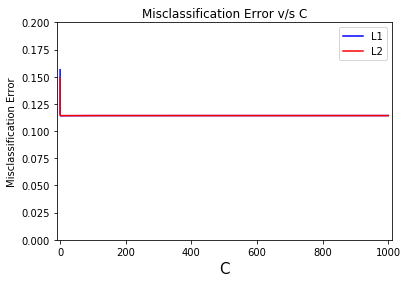

In [55]:
plot_error_vs_c(sol_w2v)

Accuracy on test set: 87.55
Precision on test set: 82.05
Recall on test set: 71.64
F1-Score on test set:  75.13
Non Zero weights: 50


Text(0.5,15,'Predicted label')

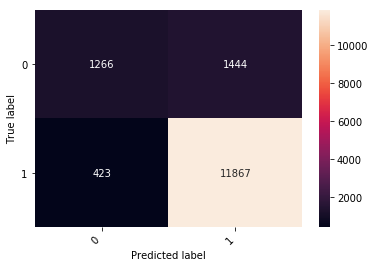

In [56]:
#Testing Accuracy on Test data
import numpy as np
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Precision on test set:",np.round((precision_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Recall on test set:",np.round((recall_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,y_pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [57]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.55
F1-Score on test set:  75.12
Non Zero weights: 50


In [58]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.55
F1-Score on test set:  75.11
Non Zero weights: 50


In [59]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.55
F1-Score on test set:  75.11
Non Zero weights: 50


# Randomized search

In [60]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}

sol_w2v_random = RandomizedSearchCV(clf,param_grid,verbose=1)
sol_w2v_random.fit(X_train,y_train)

print("Best HyperParameter: ",sol_w2v_random.best_params_)
print("Best Accuracy: %.2f%%"%(sol_w2v_random.best_score_*100))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   25.1s finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 88.58%


Accuracy on test set: 87.65
Precision on test set: 82.14
Recall on test set: 72.0
F1-Score on test set:  75.46
Non Zero weights: 50


Text(0.5,15,'Predicted label')

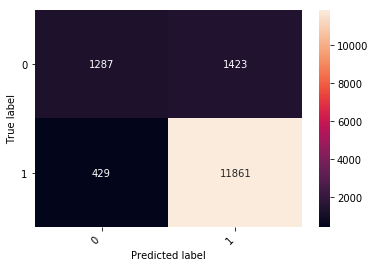

In [98]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Precision on test set:",np.round((precision_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Recall on test set:",np.round((recall_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("F1-Score on test set: ",np.round((f1_score(y_test, y_pred,average= 'macro')*100),decimals = 2))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,y_pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [99]:
def plot_error_vs_c(sol_w2v_random):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    
    for a in sol_w2v_random.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1 - a[1])
            x1.append(a[0]['C'])
            
        else:
            y2.append(1 - a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()

/home/joseph/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


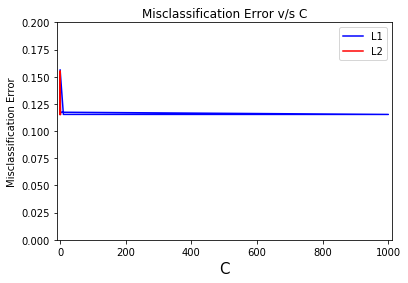

In [100]:
plot_error_vs_c(sol_w2v_random)

# Perturbation test

In [101]:
clf = LogisticRegression(C = 10, penalty = 'l2')

clf.fit(X_train, y_train)

print("Accuracy on test set:",np.round((accuracy_score(y_test, y_pred)*100),decimals = 2))
print("Non zero weights:" , np.count_nonzero(clf.coef_))

Accuracy on test set: 87.65
Non zero weights: 50


In [102]:
from scipy.sparse import find

#weights before adding random noise

weights1 = find(clf.coef_)[2]

print(weights1)

[-0.41194378  0.11339575  0.11142185 -0.74530152  1.46478568  0.29970845
 -0.20322738  0.59865603  1.0642619  -0.50646863 -0.17550277  0.61771242
 -0.2142788  -0.032358   -0.72643719  0.72876412  0.3184239   0.77935938
  1.5609346  -0.04872308 -0.09619143 -0.31216177 -0.2866306   0.69359366
 -0.37050986  0.97977291 -1.20701183 -1.28446447 -0.09360631 -0.47595043
  0.67591167  0.48351287 -0.45066732  0.78477557  0.34005925 -0.27617105
  0.35842102 -0.47297058  1.05961788  0.23020914  0.03216053  1.29648086
 -0.90176404  0.61964764 -0.31346482 -0.18746035  0.34083964  1.30850203
  1.12941658 -0.04247589]


In [103]:
X_train_2 = X_train

epsilon = np.random.uniform(low = -0.0001, high = 0.0001, size = (find(X_train_2)[0].size,))

#print(type(X_train_2))

# positions(row,cloumn) and value of non-zero datapoints
a,b,c = find(X_train_2)


X_train_2[a,b] = epsilon + X_train_2[a,b] 

TypeError: list indices must be integers or slices, not tuple